# Drug Side Effect Prediction - Armaan Sait - CS5100

# SetUp

In [92]:
# Importing Modules for Data manupulation and Visualization
import pandas as pd   
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

# Importing Modules for Machine Learning
import pickle
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load Data

In [93]:
# Download and Load the SIDER Dataset
def load_data():
    side_effects_url = "http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz"
    drug_names_url = "http://sideeffects.embl.de/media/download/drug_names.tsv"
    disease_data_url = "https://www.kaggle.com/api/v1/datasets/download/manncodes/drug-prescription-to-disease-dataset?dataset_version_number=1"

    
    side_effects_df = pd.read_csv(
        side_effects_url,
        sep='\t',
        compression='gzip',
        names=[
            'compound_id_flat', 
            'compound_id_stereo', 
            'label_umls_id', 
            'meddra_type', 
            'meddra_umls_id', 
            'side_effect_name'
        ]
    )
    drug_names_df = pd.read_csv(drug_names_url, sep='\t', names=['compound_id_flat', 'drug_name'])
    disease_data_df = pd.read_csv(disease_data_url, sep=',', compression='zip')[['disease', 'drug']]
    

    return side_effects_df, drug_names_df, disease_data_df


In [94]:
side_effects_df, drug_names_df, disease_data_df = load_data()

In [95]:
# Save each dataframe to a separate CSV file for the Website Creation later
side_effects_df.to_csv('../data/side_effects.csv', index=False)
drug_names_df.to_csv('../data/drug_names.csv', index=False)
disease_data_df.to_csv('../data/disease_data.csv', index=False)

# Data EDA

### Check for missing values

In [34]:
# Checking for Missing Values
missing_in_side_effect = {col: count for col, count in side_effects_df.isnull().sum().items() if count > 0}
print(f"\nMissing values in Side Effects DataFrame: {missing_in_side_effect if missing_in_side_effect else 'None'}")

missing_in_drug_names = {col: count for col, count in drug_names_df.isnull().sum().items() if count > 0}
print(f"\nMissing values in Drug Names DataFrame: {missing_in_drug_names if missing_in_drug_names else 'None'}")

missing_in_disease_df = {col: count for col, count in disease_data_df.isnull().sum().items() if count > 0}
print(f"\nMissing values in Disease Data DataFrame: {missing_in_disease_df if missing_in_disease_df else 'None'}")


Missing values in Side Effects DataFrame: {'meddra_type': 901, 'meddra_umls_id': 901}

Missing values in Drug Names DataFrame: None

Missing values in Disease Data DataFrame: None


### Dropping Duplicates 

In [ ]:
disease_data_df = disease_data_df.drop_duplicates() # Dropping duplicates because duplicates present in source

### Combining multiple dataframes

In [36]:
# Perform inner join between all three dataframes
merged_df = side_effects_df.merge(drug_names_df, on='compound_id_flat').merge(disease_data_df, left_on='drug_name', right_on='drug') # 1562790 rows
drug_se_df = side_effects_df.merge(drug_names_df, on='compound_id_flat') # 309849 rows

### Data Analytics

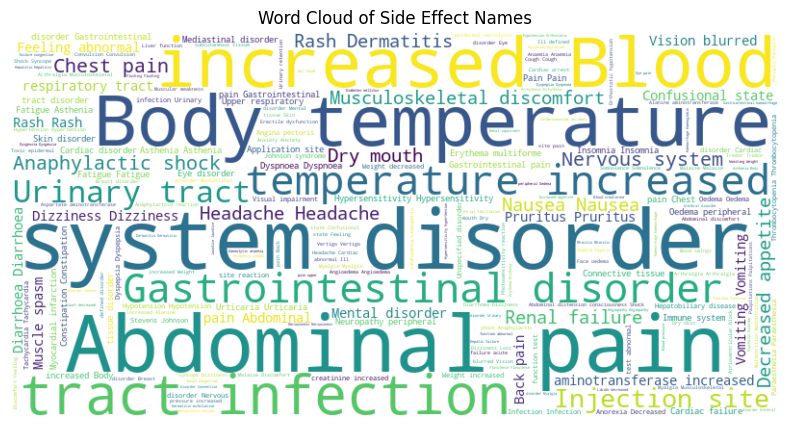

In [37]:
# Generate a word cloud for side effect names
side_effects_text = ' '.join(side_effects_df['side_effect_name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(side_effects_text)

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Side Effect Names')
plt.show()

## These show the side effects which occur the most

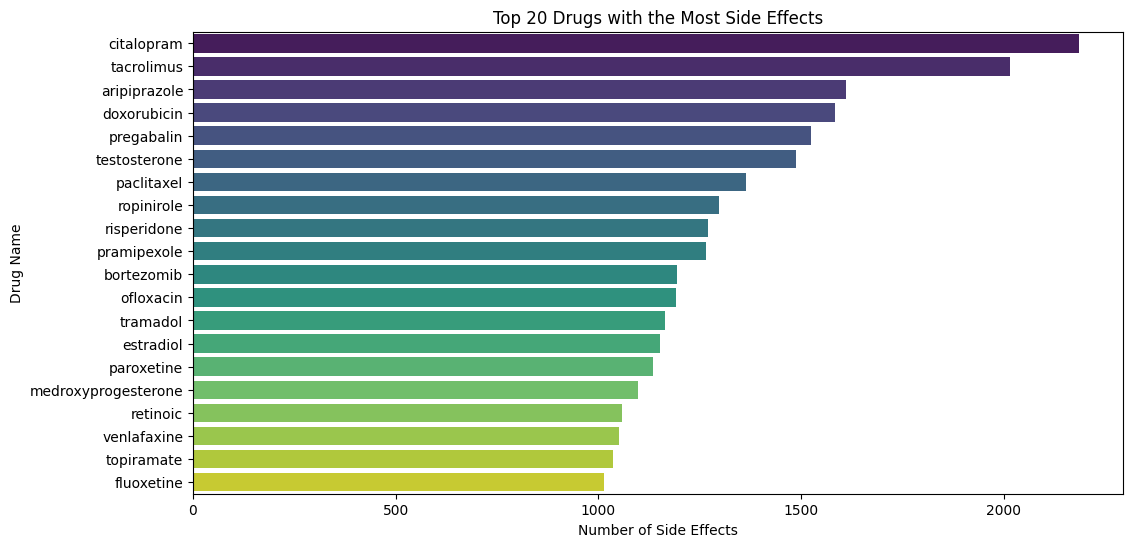

In [38]:
# Count the number of side effects per drug
side_effects_count = drug_se_df['drug_name'].value_counts().reset_index()
side_effects_count.columns = ['drug_name', 'side_effect_count']

# Plotting the top 20 drugs with the most side effects
plt.figure(figsize=(12, 6))
sns.barplot(
    x='side_effect_count', 
    y='drug_name', 
    data=side_effects_count.head(20), 
    hue='drug_name',  # Assigning hue to the y variable
    dodge=False,  # To avoid bars overlapping due to hue
    palette='viridis', 
    legend=False  # Hiding the legend since we only need a color mapping
)
plt.title('Top 20 Drugs with the Most Side Effects')
plt.xlabel('Number of Side Effects')
plt.ylabel('Drug Name')
plt.show()

## The above plot shows the top 20 drugs with the most side effects.

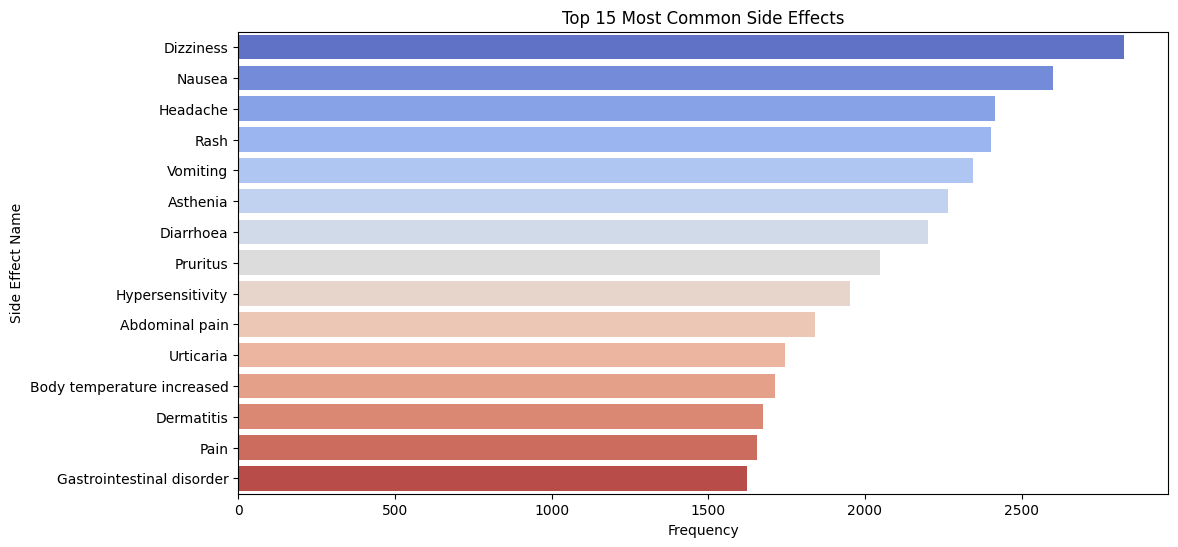

In [39]:
common_side_effects = side_effects_df['side_effect_name'].value_counts().reset_index()
common_side_effects.columns = ['side_effect_name', 'count']

# Plotting the top 15 most common side effects
plt.figure(figsize=(12, 6))
sns.barplot(
    x='count', 
    y='side_effect_name', 
    data=common_side_effects.head(15), 
    hue='side_effect_name',
    dodge=False,
    palette='coolwarm', 
    legend=False
)
plt.title('Top 15 Most Common Side Effects')
plt.xlabel('Frequency')
plt.ylabel('Side Effect Name')
plt.show()

## The graph below shows the most common side effects that occur in patients.

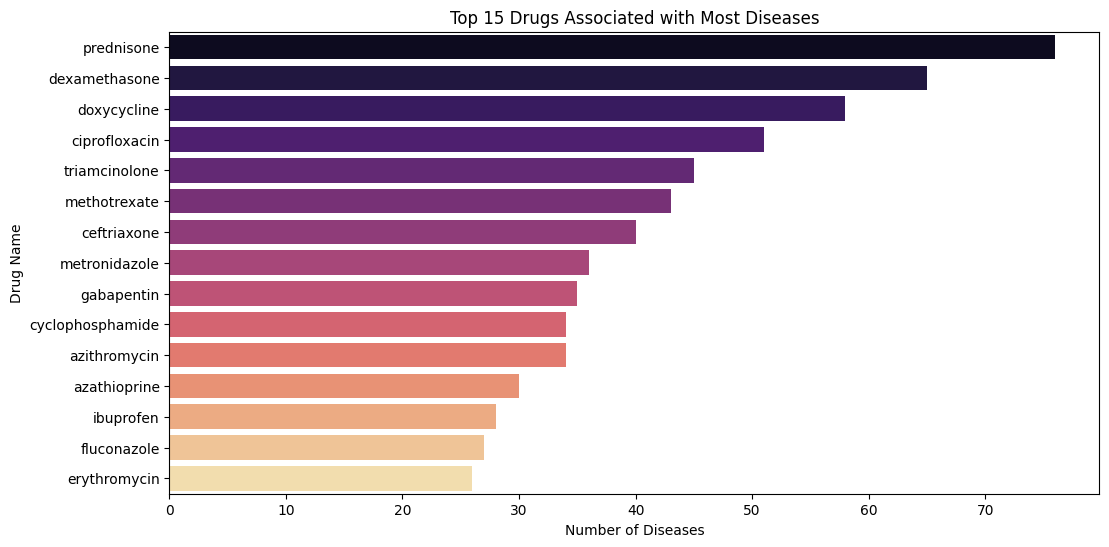

In [40]:
# Top 15 Drugs associated with the most diseases
# Count the number of diseases associated with each drug
disease_count = disease_data_df['drug'].value_counts().reset_index()
disease_count.columns = ['drug_name', 'disease_count']

# Plotting the top 15 drugs associated with the most diseases
plt.figure(figsize=(12, 6))
sns.barplot(
    x='disease_count', 
    y='drug_name', 
    data=disease_count.head(15), 
    hue='drug_name',
    dodge=False,
    palette='magma', 
    legend=False
)
plt.title('Top 15 Drugs Associated with Most Diseases')
plt.xlabel('Number of Diseases')
plt.ylabel('Drug Name')
plt.show()

## The graph below shows the top 15 drugs that are associated with the most diseases.

# Model Creation

### Common Function to reuse and store results

In [ ]:
## Here we are going to preprocess the data for the machine learning model
## We are going to use the side effects and drug names dataframes to create a pivot table
## The pivot table will have the drug names as the index and the side effects as the columns
## The values will be 1 if the side effect is present for the drug and 0 if it is not present


def preprocess_data(side_effects_df, drug_names_df):
    data = side_effects_df.merge(drug_names_df, on='compound_id_flat')
    data['presence'] = 1
    pivot_df = data.pivot_table(index='drug_name', columns='side_effect_name', 
                                values='presence', fill_value=0)
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]
    return pivot_df

In [70]:
# Store Results Across modules
results = []

def append_results(model_name, accuracy, precision, recall, f1_score):
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

### Training LightGBM

In [ ]:
## Train and Test the LightGBM Model
## We pass the X_train, X_test, y_train, y_test, and the number of classes to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_lightgbm_model(X_train, X_test, y_train, y_test, n_classes):
    # Initialize LightGBM model
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=n_classes,
        metric='multi_logloss',
        boosting_type='gbdt',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100
    )
    
    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_logloss')
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return model, y_test, y_pred, accuracy, report


### Train CatBoost

In [72]:
## Train and Test the CatBoost Model
## We pass the X_train, X_test, y_train, and the y_test to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_catboost_model(X_train, X_test, y_train, y_test):
    # Initialize CatBoost model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        verbose=10
    )
    
    # Train the model
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()  # Ensure y_pred matches expected shape
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return model, y_test, y_pred, accuracy, report


### Train Adaboost

In [ ]:
## Train and Test the AdaBoost Model
## We pass the X_train, X_test, y_train, and the y_test to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_adaboost_model(X_train, X_test, y_train, y_test):
    # Initialize AdaBoost model
    base_estimator = DecisionTreeClassifier(max_depth=1)  # Weak learner
    model = AdaBoostClassifier(
        estimator=base_estimator,
        algorithm='SAMME',
        n_estimators=100,
        learning_rate=0.1
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return model, y_test, y_pred, accuracy, report

### Train XGBoost

In [ ]:
## Train and Test the AdaBoost Model
## We pass the X_train, X_test, y_train, and the y_test to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_xgboost_model(X_train, X_test, y_train, y_test, n_classes):
    # Initialize and train XGBoost classifier with the correct number of classes
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=n_classes,
        eval_metric='mlogloss',
        use_label_encoder=False  # Add this parameter
    )
    
    # Convert labels to integer type
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    # Create DMatrix for XGBoost (optional but can help prevent issues)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Set up parameters
    params = {
        'objective': 'multi:softmax',
        'num_class': n_classes,
        'eval_metric': 'mlogloss',
        'max_depth': 6,
        'eta': 0.3,
        'min_child_weight': 1
    }
    
    # Train the model using the lower-level API
    num_rounds = 100
    model = xgb.train(params, dtrain, num_rounds)
    
    # Make predictions
    y_pred = model.predict(dtest)
    y_pred = y_pred.astype(int)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    
    return model, y_test, y_pred, accuracy, report

### Train RandomForest

In [67]:
def train_random_forest_model(X_train, X_test, y_train, y_test):
    # Initialize and train the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return rf_model, y_test, y_pred, accuracy, report

### Common Function to Trigger the respective models

In [58]:
def train_boosting_models(pivot_df, model_type):
    # Prepare feature matrix X and labels y
    X = pivot_df.dropna(axis=1, how='all').values
    y = pivot_df.idxmax(axis=1).values  # Using the most frequent side effect as the label
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
    n_classes = len(np.unique(y_encoded))
    
    # Ensure test labels exist in train labels
    train_classes = set(np.unique(y_train))
    test_classes = set(np.unique(y_test))
    unseen_classes = test_classes - train_classes

    if unseen_classes:
        valid_indices = [i for i, label in enumerate(y_test) if label in train_classes]
        X_test = X_test[valid_indices]
        y_test = y_test[valid_indices]


    if model_type == 'lightgbm':
        return train_lightgbm_model(X_train, X_test, y_train, y_test, n_classes)
    elif model_type == 'catboost':
        return train_catboost_model(X_train, X_test, y_train, y_test)
    elif model_type == 'adaboost':
        return train_adaboost_model(X_train, X_test, y_train, y_test)
    elif model_type == 'xgboost':
        return train_xgboost_model(X_train, X_test, y_train, y_test, n_classes)
    elif model_type == 'random_forest':
        return train_random_forest_model(X_train, X_test, y_train, y_test)
    else:
        raise ValueError("Invalid model_type! Choose from 'lightgbm', 'catboost', 'xgboost', or 'adaboost'.")

### CatBoost Model

In [73]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='catboost')
print("\n--- CatBoost Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("CatBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...
0:	learn: 3.4116402	test: 3.2134889	best: 3.2134889 (0)	total: 6.09s	remaining: 10m 3s
10:	learn: 2.1619148	test: 1.8515316	best: 1.8515316 (10)	total: 51.7s	remaining: 6m 57s
20:	learn: 1.8964201	test: 1.5814837	best: 1.5814837 (20)	total: 1m 48s	remaining: 6m 46s
30:	learn: 1.7812602	test: 1.4798173	best: 1.4798173 (30)	total: 2m 25s	remaining: 5m 24s
40:	learn: 1.6988534	test: 1.4169906	best: 1.4169906 (40)	total: 2m 57s	remaining: 4m 15s
50:	learn: 1.6483250	test: 1.3800336	best: 1.3800336 (50)	total: 3m 27s	remaining: 3m 19s
60:	learn: 1.5971913	test: 1.3507797	best: 1.3507797 (60)	total: 4m	remaining: 2m 33s
70:	learn: 1.5562444	test: 1.3265662	best: 1.3265662 (70)	total: 4m 32s	remaining: 1m 51s
80:	learn: 1.5085235	test: 1.2964042	best: 1.2964042 (80)	total: 5m 8s	remaining: 1m 12s
90:	learn: 1.4832313	test: 1.2820929	best: 1.2820929 (90)	total: 6m 26s	remaining: 38.2s
99:	learn: 1.4555701	test: 1.2651964	best: 1.2651964 (99)	total: 7m 1s	remaining: 0us

b

### LightGBM Model

In [74]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='lightgbm')
print("\n--- LightBoost Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")


append_results("LightBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 942, number of used features: 921
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -5.749393
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -5.461711
[LightGBM] [Info] Start training from score -6.154858
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -6.848005
[LightGBM] [Info] Start training from score -3.110336
[LightGBM] [Info] Start training

### AdaBoost Model

In [75]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='adaboost')
print("\n--- AdaBoost Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("AdaBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...

--- AdaBoost Results ---

Overall Performance Metrics:
Accuracy:  0.493
Precision: 0.335
Recall:    0.493
F1-Score:  0.357
Total samples (support): 375


### XGBOOST Model

In [76]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='xgboost')

print("\n--- XGBOOST Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("XGBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...

--- XGBOOST Results ---

Overall Performance Metrics:
Accuracy:  0.853
Precision: 0.914
Recall:    0.853
F1-Score:  0.838
Total samples (support): 375


### RandomForest Model

In [77]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='random_forest')

print("\n--- Random Forest Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("RandomForest", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...

--- Random Forest Results ---

Overall Performance Metrics:
Accuracy:  0.621
Precision: 0.601
Recall:    0.621
F1-Score:  0.553
Total samples (support): 375


# Results

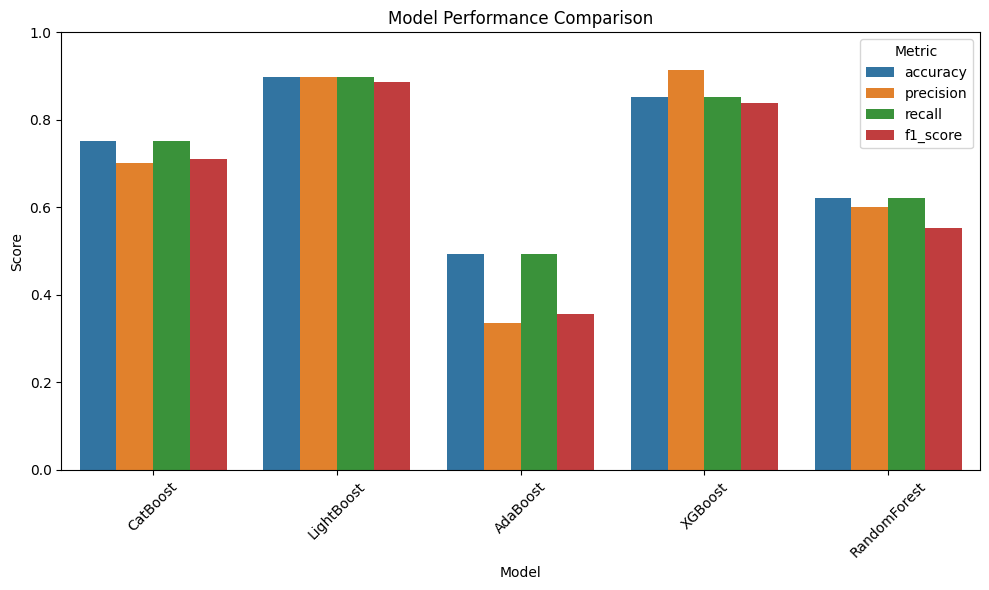

In [80]:
results_df = pd.DataFrame(results)
results_melted = results_df.melt(id_vars='model', var_name='Metric', value_name='Score')

# Plot metrics for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

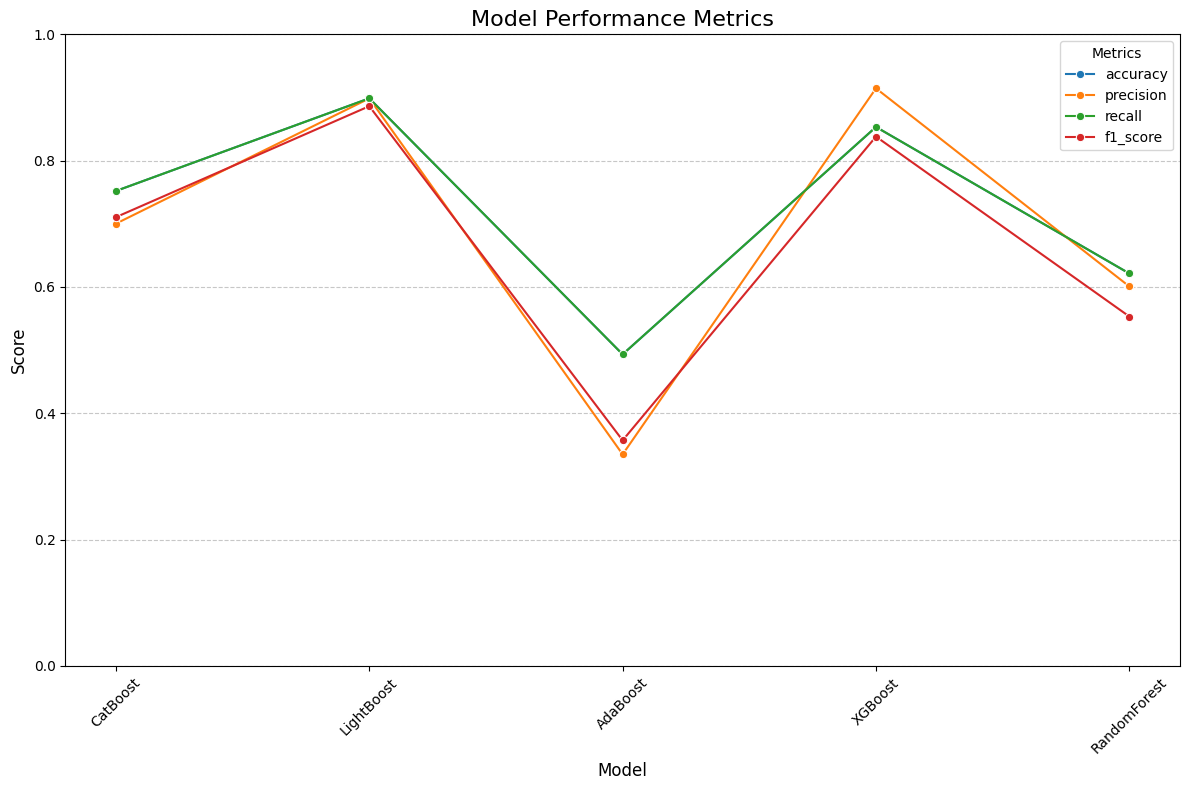

In [85]:
plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    sns.lineplot(data=results_df, x='model', y=metric, marker='o', label=metric)

plt.title('Model Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Metrics', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

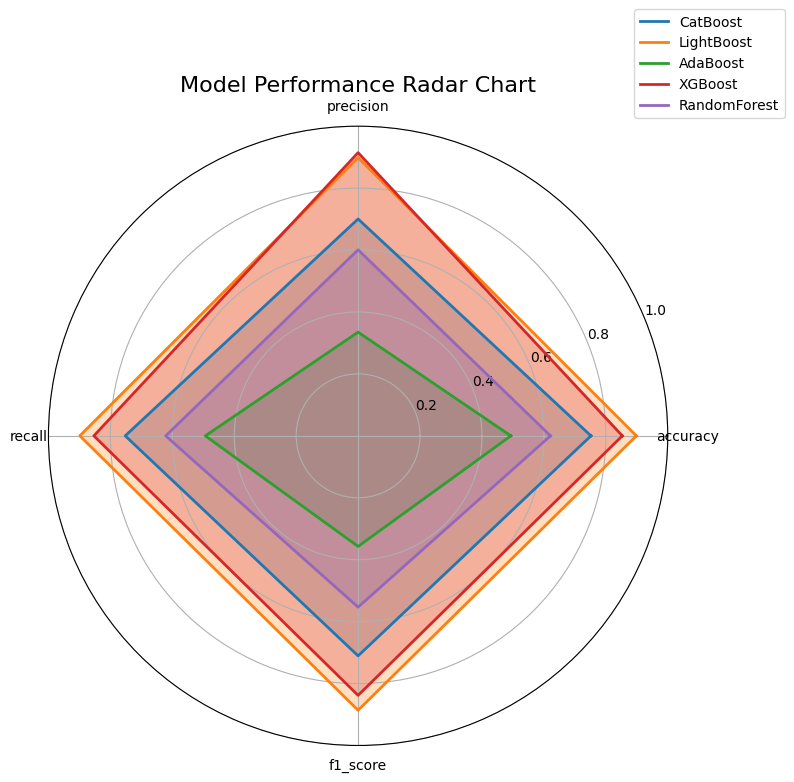

In [89]:
from math import pi

def radar_chart(results_df):
    categories = ['accuracy', 'precision', 'recall', 'f1_score']
    N = len(categories)

    # Normalize metrics for radar chart
    values = [results_df[categories].iloc[i].tolist() + [results_df[categories].iloc[i].tolist()[0]] for i in range(len(results_df))]
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for i, model in enumerate(results_df['model']):
        ax.plot(angles, values[i], label=model, linewidth=2)
        ax.fill(angles, values[i], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax.set_title("Model Performance Radar Chart", fontsize=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
    plt.tight_layout()
    plt.show()

radar_chart(results_df)


In [90]:
results_df_path = f"../model/all_model_results.json"
results_df.to_json(results_df_path, orient="records", indent=4)